In [11]:
import pandas as pd
import random
import torch
import string
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

In [12]:
def generate_anbn(n, n1, min_size=0, max_size=50):
    x = []
    y = []
    for i in range(n):
        size = random.randint(min_size, max_size)
        a_size = random.randint(0, size)
        b_size = size - a_size

        s = 'a'*a_size +'b'*b_size
        x.append(s)
        if(a_size == b_size):
            y.append(1)
        else:
            y.append(0)
    
    # for make sure there are enough members, we generate n1 members directly for dataset.
    if min_size < max_size:
        for i in range(n1):
            size = random.randint(min_size//2, (max_size)//2)*2
            a_size = size//2

            s = 'a'*a_size +'b'*a_size
            x.append(s)
            y.append(1)
    x_encoded = list(map(lambda s: torch.from_numpy(np.array([0]*s.count('a')+[1]*s.count('b')).astype(np.int32)), x))
    y_encoded = list(map(lambda s: torch.from_numpy(np.array([s]).astype(np.int32)), y))
    return x_encoded, y_encoded

def generate_anbncn(n, n1, min_size=0, max_size=50):
    x = []
    y = []
    for i in range(n):
        size = random.randint(min_size, max_size)
        t_size = random.randint(0, size)
        l_size = random.randint(0, t_size)
        r_size = random.randint(t_size, size)
        a_size = l_size
        b_size = r_size - l_size
        c_size = size - r_size

        s = 'a'*a_size +'b'*b_size + 'c'*c_size
        x.append(s)
        if(a_size == b_size == c_size):
            y.append(1)
        else:
            y.append(0)
    
    # for make sure there are enough members, we generate n1 members directly for dataset.
    if min_size < max_size:
        for i in range(n1):
            size = random.randint(min_size//3, (max_size)//3)*3
            a_size = size//3

            s = 'a'*a_size +'b'*a_size + 'c'*a_size
            x.append(s)
            y.append(1)
    x_encoded = list(map(lambda s: torch.from_numpy(np.array([0]*s.count('a')+[1]*s.count('b')+[2]*s.count('c')).astype(np.int32)), x))
    y_encoded = list(map(lambda s: torch.from_numpy(np.array([s]).astype(np.int32)), y))
    return x_encoded, y_encoded



In [13]:
x_encoded, y_encoded = generate_anbn(500, 500, 2, 20)
x_encoded_anbncn, y_encoded_anbncn = generate_anbncn(500, 500, 3, 20)
X_train, X_valid, y_train, y_valid = train_test_split(x_encoded, y_encoded, test_size=0.3)
train_valid_set = [X_train] + [X_valid] + [y_train] + [y_valid]
X_train_anbncn, X_valid_anbncn, y_train_anbncn, y_valid_anbncn = train_test_split(x_encoded_anbncn, y_encoded_anbncn, test_size=0.3)
train_valid_set_anbncn = [X_train_anbncn] + [X_valid_anbncn] + [y_train_anbncn] + [y_valid_anbncn]

In [14]:

def train_model(model, train_valid_set, epochs=10, lr=0.001):
    loss_function=nn.NLLLoss()
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)

    all_loss = []
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in zip(train_valid_set[0], train_valid_set[2]):
            x = x.long()
            y = y.long()
            model.zero_grad()
            model.hidden = model.init_hidden()
            y_pred = model(x)
            # optimizer.zero_grad()
            # print(y_pred)
            # print(y_pred.size())
            loss = loss_function(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, train_valid_set, loss_function)
        # if i % 5 == 1:
        all_loss.append(sum_loss/total)
        print("train loss %f, val loss %f, val accuracy %f, and val rmse %f" % (sum_loss/total, val_loss, val_acc, val_rmse))
    return all_loss

def validation_metrics (model, train_valid_set, loss_function):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y in zip(train_valid_set[1], train_valid_set[3]):
        x = x.long()
        y = y.long()
        model.zero_grad()
        model.hidden = model.init_hidden()
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        ttt = torch.max(y_hat, 1)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [15]:
class LSTMTagger(torch.nn.Module):
    def __init__(self,embedding_dim,hidden_dim,voacb_size,target_size):
        super(LSTMTagger,self).__init__()
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.voacb_size=voacb_size
        self.target_size=target_size
        self.embedding=nn.Embedding(self.voacb_size,self.embedding_dim)
        self.lstm=nn.LSTM(self.embedding_dim,self.hidden_dim)
        self.out2tag=nn.Linear(self.hidden_dim,self.target_size)

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self,inputs):
        embeds=self.embedding((inputs))
        t = embeds.view(len(inputs),1,-1)
        out,(ht, ct)=self.lstm(t,self.hidden)
        tag_space=self.out2tag(ht.view(-1, self.hidden_dim))
        tags=F.log_softmax(tag_space,dim=1)
        return tags

class RNNTagger(torch.nn.Module):
    def __init__(self,embedding_dim,hidden_dim,voacb_size,target_size):
        super(RNNTagger,self).__init__()
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.voacb_size=voacb_size
        self.target_size=target_size
        self.embedding=nn.Embedding(self.voacb_size,self.embedding_dim)
        self.lstm=nn.RNN(self.embedding_dim,self.hidden_dim)
        self.out2tag=nn.Linear(self.hidden_dim,self.target_size)

        self.hidden = self.init_hidden()

    def init_hidden(self):
       
        return torch.zeros(1, 1, self.hidden_dim)

    def forward(self,inputs):

        embeds=self.embedding((inputs))
        t = embeds.view(len(inputs),1,-1)
        out, ht=self.lstm(t,self.hidden)

        tag_space=self.out2tag(ht.view(-1, self.hidden_dim))
        tags=F.log_softmax(tag_space,dim=1)
        return tags


train loss 0.559825, val loss 0.482693, val accuracy 0.780000, and val rmse 0.220000
train loss 0.477210, val loss 0.448095, val accuracy 0.786667, and val rmse 0.213333
train loss 0.429489, val loss 0.378976, val accuracy 0.846667, and val rmse 0.153333
train loss 0.376691, val loss 0.342761, val accuracy 0.870000, and val rmse 0.130000
train loss 0.325364, val loss 0.283914, val accuracy 0.880000, and val rmse 0.120000
train loss 0.240675, val loss 0.186483, val accuracy 0.966667, and val rmse 0.033333
train loss 0.186711, val loss 0.150246, val accuracy 0.966667, and val rmse 0.033333
train loss 0.158520, val loss 0.103883, val accuracy 0.970000, and val rmse 0.030000
train loss 0.139242, val loss 0.091045, val accuracy 0.970000, and val rmse 0.030000
train loss 0.136853, val loss 0.098348, val accuracy 0.966667, and val rmse 0.033333
train loss 0.110014, val loss 0.064265, val accuracy 0.973333, and val rmse 0.026667
train loss 0.098934, val loss 0.112338, val accuracy 0.970000, an

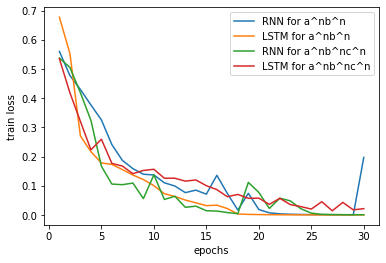

In [17]:
num_epochs = 30
learn_rate = 0.0005
model_LSTMTagger = LSTMTagger(2, 128, 2, 2)
model_RNNTagger = RNNTagger(2, 128, 2, 2)
model_LSTMTagger_anbncn = LSTMTagger(3, 128, 3, 2)
model_RNNTagger_anbncn = RNNTagger(3, 128, 3, 2)
loss_RNN = train_model(model_RNNTagger, train_valid_set, epochs=num_epochs, lr=learn_rate)
loss_LSTM = train_model(model_LSTMTagger, train_valid_set, epochs=num_epochs, lr=learn_rate)
loss_RNN_anbncn = train_model(model_RNNTagger_anbncn, train_valid_set_anbncn, epochs=num_epochs, lr=learn_rate)
loss_LSTM_anbncn = train_model(model_LSTMTagger_anbncn, train_valid_set_anbncn, epochs=num_epochs, lr=learn_rate)
plot_x = [i for i in range(1,31)]
plt.plot(plot_x, loss_RNN, label='RNN for a^nb^n')
plt.plot(plot_x, loss_LSTM, label='LSTM for a^nb^n')
plt.plot(plot_x, loss_RNN_anbncn, label='RNN for a^nb^nc^n')
plt.plot(plot_x, loss_LSTM_anbncn, label='LSTM for a^nb^nc^n')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.legend()
plt.show()

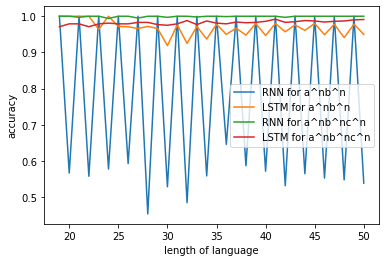

In [18]:
def evaluate_testset(str, model):
    model.hidden = model.init_hidden()
    output = model(str)
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i

def evaluate_accuracy(model, dataset=0):
    plot_y = []
    for i in range(19, 51):
        if dataset == 0:
            x_test, y_test = generate_anbn(1000, 0, i, i)
        else:
            x_test, y_test = generate_anbncn(1000, 0, i, i)
        preds = [0, 0, 0, 0]
        # acc = 0
        # num = 0
        for x, y in zip(x_test, y_test):
            model.hidden = model.init_hidden()
            output = model(x)
            top_n, top_i = output.topk(1)
            pred = top_i[0].item()
            if pred == 1 and torch.equal(y, torch.tensor([1], dtype=torch.int32)):
                preds[0] += 1
            elif pred == 1 and torch.equal(y, torch.tensor([0], dtype=torch.int32)):
                preds[1] += 1
            elif pred == 0 and torch.equal(y, torch.tensor([1], dtype=torch.int32)):
                preds[2] += 1
            elif pred == 0 and torch.equal(y, torch.tensor([0], dtype=torch.int32)):
                preds[3] += 1
        plot_y.append((preds[0]+preds[3])/sum(preds))
    return plot_y

acc_RNN = evaluate_accuracy(model_RNNTagger, 0)
acc_RNN_anbncn = evaluate_accuracy(model_RNNTagger_anbncn, 1)
acc_LSTM = evaluate_accuracy(model_LSTMTagger, 0)
acc_LSTM_anbncn = evaluate_accuracy(model_LSTMTagger_anbncn, 1)
plot_x = [i for i in range(19, 51)]
plt.plot(plot_x, acc_RNN, label='RNN for a^nb^n')
plt.plot(plot_x, acc_LSTM, label='LSTM for a^nb^n')
plt.plot(plot_x, acc_RNN_anbncn, label='RNN for a^nb^nc^n')
plt.plot(plot_x, acc_LSTM_anbncn, label='LSTM for a^nb^nc^n')
plt.xlabel('length of language')
plt.ylabel('accuracy')
plt.legend()
plt.show()